# Compare between scenarios

## 1. Prepare Base Config
Prepare the base configuration based on the function in plot_KPIs

In [55]:
import sys
import os
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from pypsa.plot import add_legend_circles, add_legend_patches
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
from matplotlib import rc

from matplotlib.colors import Normalize
import country_converter as coco

cc = coco.CountryConverter()

rc('axes', **{'edgecolor': 'None', 'titlesize': 18,'titleweight': 'bold', "labelsize": 14})
rc('figure', **{'edgecolor': 'None'})
rc('patch', **{'edgecolor': 'None'})
rc('savefig', **{'edgecolor': 'None'})
rc('legend', **{'fontsize': 12, 'title_fontsize': 12})
rc('xtick', **{'labelsize': 12})
rc('ytick', **{'labelsize': 12})
# plt.style.use(["ggplot"])

relative_path = '../scripts'
absolute_path = os.path.abspath(relative_path)
sys.path.append(absolute_path)

from plot_power_network import load_projection, test_and_enable_latex
from plot_summary import preferred_order
from plot_validation_cross_border_flows import sort_one_country, color_country

from plot_KPIs import *

power_generation_tech = pd.Index([
    "solar rooftop",
    "Solar",
    "solar-hsat",
    "Onshore Wind",
    "Offshore Wind (DC)",
    "Offshore Wind (AC)",
    "Offshore Wind (Floating)",
    "Run of River",
    "Reservoir & Dam",
    "Open-Cycle Gas",
    "OCGT",
    "Combined-Cycle Gas",
    "CCGT",
    "nuclear",
    "oil",
    "lignite",
    "coal",
    "urban central CHP",
    "urban central CHP CC",
    "urban central solid biomass CHP",
    "urban central solid biomass CHP CC",
])

tech_colors_custom = {
    "H2 Electrolysis": "#ff29d9",
    "SMR": "#f073da",
    "SMR CC": "#c251ae",
    "Fischer-Tropsch": "#25c49a",
    "H2 Fuel Cell": "#2d8077",
    "H2 for industry": "#cd4f41",
    "H2 for shipping": "#238fc4",
    "Sabatier": "#de9e46",
    "methanation": "#de9e46",
    "Reservoir \& Dam": '#298c81',
    "Reservoir & Dam": '#298c81',
    "Solar Thermal": '#d7b24c',
    "Solar (HSAT)": "#fdb915",
    "Solar PV (utility)": "#f9d002",
    "Solar PV (rooftop)": '#ffea80',
    'Offshore Wind': "#6895dd",
    'Offshore Wind (AC)': "#6895dd",
    'Offshore Wind (DC)': "#74c6f2",
    'Offshore Wind (Floating)': "#b5e2fa",
    "Onshore Wind": "#235ebc",
    "Run of River": '#3dbfb0',
    "residential urban decentral gas boiler": "#de9e46",
    "Hydroelectricity": '#298c81',
    "Gas Turbine": '#a85522',
}

pretty_gen = {
    "onwind": "Onshore Wind",
    "offwind-ac": "Offshore Wind (AC)",
    "offwind-dc": "Offshore Wind (DC)",
    "offwind-float": "Offshore Wind (Floating)",
    "solar": "Solar",
}

# choose pretty names
pretty_names = {
    "lair": "Liquid Air energy storage",
    "pair": "Adiabatic CAES",
    "vanadium": "Vanadium-Redox Battery Storage",
    "li-ion battery": "Li-Ion Battery Storage",
    "li-ion battery 1h": "Li-Ion Battery Storage 1h",
    "li-ion battery 2h": "Li-Ion Battery Storage 2h",
    "li-ion battery 4h": "Li-Ion Battery Storage 4h",
    "li-ion battery 8h": "Li-Ion Battery Storage 8h",
    "iron-air battery": "Iron-Air Battery Storage",
    "H2 Electrolysis": "H2 electrolysis",
    "H2 Fuel Cell": "H2 fuel cell",
    "Offshore Wind (AC)": "Offshore Wind", # Special Case: aggregate all offshore wind to one
    "Offshore Wind (DC)": "Offshore Wind",
    "Offshore Wind (Floating)": "Offshore Wind",
    "offshore wind (AC)": "Offshore Wind",
    "offshore wind (DC)": "Offshore Wind",
    "offwind-ac": "Offshore Wind",
    "offwind-dc": "Offshore Wind",
    "offwind-float": "Offshore Wind",
    "offshore wind": "Offshore Wind",
    "onwind": "Onshore Wind",
    "onshore wind": "Onshore Wind",
    "solar PV": "Solar PV (utility)", # Special Case: aggregate pv to utility and rooftop
    "solar": "Solar PV (utility)",
    "Solar": "Solar PV (utility)",
    "solar-hsat": "Solar PV (utility)", 
    "solar rooftop": "Solar PV (rooftop)",
    "hydro": "Hydroelectricity",
    "Reservoir & Dam": "Hydroelectricity", #"Reservoir \& Dam", # Note, revert this back to /&
    "hydroelectricity": "Hydroelectricity", # Special Case: aggregate ror and hydro to hydroelectricty
    "ror": "Hydroelectricity",
    "Run of River": "Hydroelectricity",
    "uranium": "Uranium",
    "oil emissions": "Oil emissions",
    "process emissions": "Process emissions",
    "process emissions CC": "Process emissions CC",
    "gas": "Methane",
    "oil": "Oil",
    "oil primary": "Oil",
    "oil boiler": "Oil boiler",
    "gas boiler": "Gas boiler",
    "nuclear": "Nuclear",
    "coal": "Coal", # Special Case: aggregate lignite with coal
    "lignite": "Coal", 
    "Lignite": "Coal",
    "Combined-Cycle Gas": "Gas Turbine", # Special Case: aggregate CCGT with OCGT
    "Open-Cycle Gas": "Gas Turbine",
    "CCGT": "Gas Turbine",
    "OCGT": "Gas Turbine",
    "land transport oil": "Land transport oil demand",
    "land transport EV": "Land transport EV",
    "heat": "Heat demand",
    "electricity": "Electricity demand",
    "co2": "CO2 emissions",
    "biomass boiler": "Biomass boiler",
    "hot water storage": "Hot water storage",
    "resistive heater": "Resistive heater",
    "electricity distribution grid": "Electricity distribution grid",
    "transmission lines": "Transmission lines",
    "V2G": "Vehicle-to-Grid",
}

sector_colors = {
    "Power Sector": '#ffbf2b',
    "Transport Sector": '#baf238',
    "Heating Sector": '#db6a25',
    "CCUS": '#d2d2d2',
    "Primary Fuel": '#692e0a',
    "Other": 'black'
}

sector_names = {
    "Iron-Air Battery Storage": "Power Sector",
    "Li-Ion Battery Storage": "Power Sector",
    "Li-Ion Battery Storage 1h": "Power Sector",
    "Li-Ion Battery Storage 2h": "Power Sector",
    "Li-Ion Battery Storage 4h": "Power Sector",
    "Li-Ion Battery Storage 8h": "Power Sector",
    "Vanadium Redox Flow battery storage": "Power Sector",
    "Liquid Air energy storage": "Power Sector",
    "Adiabatic CAES": "Power Sector",
    "lair": "Power Sector",
    "vanadium": "Power Sector",
    "pair": "Power Sector",
    "H2 Fuel Cell": "Power Sector",
    "H2 Store": "Power Sector",
    "H2 Electrolysis": "Power Sector",
    "Pumped Hydro Storage": "Power Sector",
    "solar rooftop": "Power Sector",
    "Solar": "Power Sector",
    "solar-hsat": "Power Sector",
    "Onshore Wind": "Power Sector",
    "Offshore Wind (DC)": "Power Sector",
    "Offshore Wind (AC)": "Power Sector",
    "Offshore Wind (Floating)": "Power Sector",
    "Run of River": "Power Sector",
    "Reservoir & Dam": "Power Sector",
    "Open-Cycle Gas": "Power Sector",
    "Combined-Cycle Gas": "Power Sector",
    "nuclear": "Power Sector",
    "AC": "Power Sector",
    "DC": "Power Sector",
    "electricity distribution grid": "Power Sector",
    "H2 pipeline": "Pipeline Infrastructure",
    "H2 pipeline retrofitted": "Pipeline Infrastructure",
    "gas pipeline": "Pipeline Infrastructure",
    "gas pipeline new": "Pipeline Infrastructure",
    "BEV charger": "Transport Sector",
    "EV battery": "Transport Sector",
    "V2G": "Transport Sector",
    "land transport oil": "Transport Sector",
    "co2": "Primary Fuel",
    "co2 stored": "CCUS",
    "co2 sequestered": "CCUS",
    "DAC": "CCUS",
    "SMR CC": "Primary Fuel",
    "SMR": "Primary Fuel",
    "Sabatier": "Primary Fuel",
    "oil refining": "Primary Fuel",
    "oil primary": "Primary Fuel",
    "oil": "Primary Fuel",
    "methanol": "Primary Fuel",
    "gas": "Primary Fuel",
    "lignite": "Primary Fuel",
    "coal": "Primary Fuel",
    "uranium": "Primary Fuel",
    "biogas": "Primary Fuel",
    "biogas to gas": "Primary Fuel",
    "solid biomass": "Primary Fuel",
}

preferred_order = pd.Index([
    "Iron-Air Battery Storage",
    "Li-Ion Battery Storage",
    "lair",
    "vanadium",
    "pair",
    "H2 Fuel Cell",
    "H2 Store",
    "H2 Electrolysis",
    "Pumped Hydro Storage",
    "solar rooftop",
    "Solar",
    "solar-hsat",
    "Onshore Wind",
    "Offshore Wind (DC)",
    "Offshore Wind (AC)",
    "Offshore Wind (Floating)",
    "Run of River",
    "Reservoir & Dam",
    "Open-Cycle Gas",
    "Combined-Cycle Gas",
    "nuclear",
    "AC",
    "DC",
    "electricity distribution grid",
    "BEV charger",
    "EV battery",
    "V2G",
    "land transport oil",
    "Solar Thermal"
    "Heat Pump"
    "Resistive Heater"
    "Gas boiler"
    "Oil boiler"
    "Water Tanks"
    "heat"
    "CHP CC"
    "CHP"
    "co2",
    "co2 stored",
    "co2 sequestered",
    "DAC",
    "SMR CC",
    "SMR",
    "Sabatier",
    "oil refining",
    "oil primary",
    "oil",
    "methanol",
    "gas",
    "lignite",
    "coal",
    "uranium"
])

def filter_and_rename(network, df, filter_scheme = {}, carrier_filter = None, group_carrier = None):
    n = network.copy()

    # Replace countries with short country names
    short_name = cc.convert(names = df.columns, src = 'ISO2', to = 'name_short', not_found=None)
    if len(df.columns) == 1:
        df.columns = [short_name]
    else:
        df.columns = short_name

    # convert to nice name
    df["nice_name"] = list(pd.Series(df.index).replace(n.carriers.nice_name))
    df = df.set_index("nice_name")

    # Create your own filter
    stats = pd.DataFrame(n.statistics.energy_balance(groupby=["bus", "carrier", "bus_carrier"]))

    if carrier_filter == "electricity":
        carrier = stats[stats.index.get_level_values("bus_carrier").isin(["AC"])].index.get_level_values("carrier").unique()
        df = df.loc[df.index.isin(carrier),:]

    elif carrier_filter == "electricity+":
        carrier = stats[stats.index.get_level_values("bus_carrier").isin(["AC"])].index.get_level_values("carrier").unique()
        carrier = carrier.append(stats.filter(like="water tanks",axis=0).index.get_level_values("carrier").unique())
        carrier = carrier.append(stats.filter(like="EV battery",axis=0).index.get_level_values("carrier").unique())
        df = df.loc[df.index.isin(carrier),:]

    elif carrier_filter in filter_scheme:
        df = df.loc[df.index.isin(filter_scheme[carrier_filter]),:]

    # Group carrier
    if group_carrier == "pretty":
        df = df.rename(index=pretty_names).groupby(["nice_name"]).sum()
    elif group_carrier == "sector": 
        df = df.rename(index=sector_names).groupby(["nice_name"]).sum()

    to_drop = df.loc[abs(df.T.sum()) < 1,:].index
    # An exception if Iron Air Battery Storage is still in
    if 'Iron-Air Battery Storage' in to_drop:
        to_drop = to_drop.drop('Iron-Air Battery Storage')
    df = df.drop(to_drop)
    
    # Sort the index by preferred order and set color
    colors = n.carriers.set_index("nice_name").color.where(lambda s: s != "", "green")
    
    if group_carrier == "pretty":
        new_index = preferred_order_pretty_names_reversed.intersection(df.index).append(
            df.index.difference(preferred_order_pretty_names)
        )
        colors = colors.rename(index=pretty_names)
        colors.update(tech_colors)
        colors = colors[~colors.index.duplicated(keep='first')]
        
    elif group_carrier == "sector": 
        new_index = preferred_order_sector_names_reversed.intersection(df.index).append(
            df.index.difference(preferred_order_sector_names)
        )
        colors = sector_colors
    else:
        new_index = preferred_order_reversed.intersection(df.index).append(
            df.index.difference(preferred_order)
        )

    df["color"] = [colors[i] for i in df.index]

    return df.loc[new_index,:]

<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_59636/656928595.py:70: SyntaxWarning: invalid escape sequence '\&'
  "Reservoir \& Dam": '#298c81',


## 2. List the scenarios

In [56]:
import yaml

config = {}
for c in ["kpi","form","default"]:
    with open(f"../config/config.{c}.yaml") as file:
        config_append = yaml.safe_load(file)

    config.update(config_append)

with open("../config/scenarios.form.yaml") as file:
    config_scenarios = yaml.safe_load(file)

print("here are the list of all scenarios:")
print(list(config_scenarios.keys()))

here are the list of all scenarios:
['baseline-mds', 'baseline-nomds', 'mid-capex-mds', 'mid-capex-nomds', 'low-capex-mds', 'low-capex-nomds', 'cy2010-mds', 'cy2010-nomds', 'cy2012-mds', 'cy2012-nomds', 'cy1996-mds', 'cy1996-nomds']


## 3. Write the scenarios you want to include

In [57]:
scenarios = ['baseline-nomds', 'baseline-mds', 'mid-capex-mds', 'low-capex-mds', 'cy2012-mds', 'cy2012-nomds', 'cy1996-mds', 'cy1996-nomds',]
postnetwork = "base_s_52_lv1.11___2035.nc"

n_scenarios = {scenario:pypsa.Network(f"../results/{scenario}/{scenario}/postnetworks/{postnetwork}") for scenario in scenarios}

INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_52_lv1.11___2035.nc has buses, carrier

## 4. Prepare namings

INFO:plot_power_network:Test run latex compilation


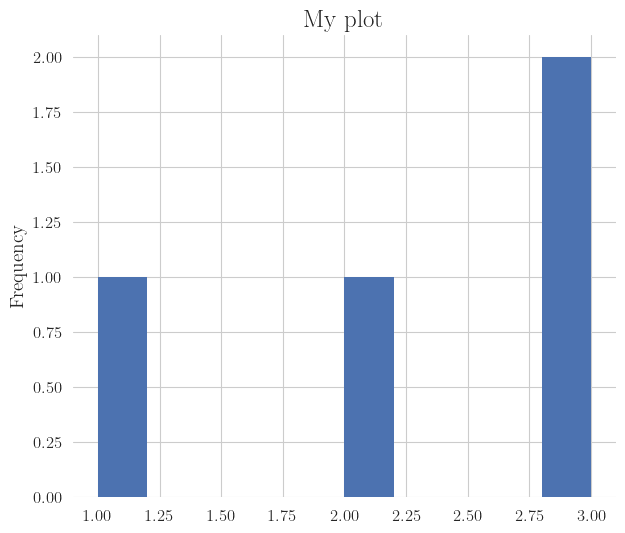

In [58]:
for scenario, n in n_scenarios.items():
    # expand the names
    pretty_names_n = expanded_pretty_names(n, pretty_names)
    sector_names_n = expanded_sector_names(n, sector_names)
    
    pretty_names.update(pretty_names_n)
    sector_names.update(sector_names_n)
    
# defined preferred order under all naming schemes
preferred_order_reversed = preferred_order[::-1]
preferred_order_pretty_names = pd.Index(pd.Series(preferred_order).apply(lambda x: pretty_names[x] if x in pretty_names.keys() else x).drop_duplicates(keep = 'first'))
preferred_order_pretty_names_reversed = preferred_order_pretty_names[::-1]

preferred_order_sector_names = pd.Index(pd.Series(preferred_order).apply(lambda x: sector_names[x] if x in sector_names.keys() else x).drop_duplicates(keep = 'first'))
preferred_order_sector_names_reversed = preferred_order_sector_names[::-1]

# define tech colors and update with custom
tech_colors = config["plotting"]["tech_colors"]
tech_colors.update(tech_colors_custom)
tech_colors = {(pretty_gen[k] if k in pretty_gen else k):v  for (k,v) in tech_colors.items()}

# test run latex compilation
config_kpi = config["kpi"]
if config_kpi.get("enable_latex", False): test_and_enable_latex()

# Plotting Comparison from KPIs Script:

In [59]:
def compare_scenarios(n_scenarios, kpi_param, filter_scheme, output):
    df_all = pd.DataFrame()
    
    countries = config["countries"]
    extract_param = kpi_param.get("extract",None)
    include = kpi_param.get("include",False)
    exclude = kpi_param.get("exclude",False)
    plot_kw = kpi_param.get("plot_kw",{})
    
    for scenario, n in n_scenarios.items():

        RESULTS = f"../../form-energy-storage/results/{scenario}/{scenario}/"
        nodal_costs=RESULTS + "csvs/nodal_costs.csv"
        nodal_capacity=RESULTS + "csvs/nodal_capacities.csv"

        if extract_param == "system cost":
            df = calculate_system_cost_csv(n, nodal_costs, countries)
        elif extract_param == "capacity":
            df = calculate_capacity_csv(n, nodal_capacity, countries)
        if extract_param == "capacity stats":
            df = calculate_capacity(n, countries, kpi_param)
        elif extract_param == "generation":
            df = calculate_generation(n, countries)
        elif extract_param == "emission":
            df = calculate_emission(n, countries)
        elif extract_param == "curtailment":
            df = calculate_curtailment(n, countries)

        if include:
            logger.info(f"include only {include}")
            df = df[include]
        if exclude:
            logger.info(f"exclude {exclude}")
            df = df.loc[:,df.columns.difference(exclude)]

        if "TW" in plot_kw.get("ylabel", ""):
            df *= 1e-3

        df = filter_and_rename(n, df, 
                               filter_scheme = filter_scheme,
                               carrier_filter = kpi_param.get("carrier_filter",None), 
                               group_carrier = kpi_param.get("group_carrier",None), 
                               )
        
        df_data = pd.DataFrame(df[df.columns.difference(['color'])].T.sum()).rename(columns={0:scenario})
        df_data["color"] = df["color"]
    
        if df_all.empty:
            df_all = df_data
        else:
            df_all = pd.concat([df_all,df_data[[scenario]]], axis=1)
            df_all["color"] = df_all["color"].combine_first(df_data["color"])
    
    display(df_all)

    if plot_kw.get("ylabel", "") == "%":
        plot_kw["ylabel"] = "\%"
    
    plot_by_country(df_all, plot_kw, output, plot_figsize = tuple(kpi_param.get("figsize",(12,9))))

<>:57: SyntaxWarning: invalid escape sequence '\%'
<>:57: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_59636/3176501291.py:57: SyntaxWarning: invalid escape sequence '\%'
  plot_kw["ylabel"] = "\%"


## a. Plot Electricity System Cost:

INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']


,baseline-nomds,color,baseline-mds,mid-capex-mds,low-capex-mds,cy2012-mds,cy2012-nomds,cy1996-mds,cy1996-nomds
Electricity distribution grid,5.932607,#97ad8c,5.894026,5.858474,5.789373,5.902955,5.932475,6.320832,6.480102
Gas Turbine,2.852596,#a85522,2.850751,2.847197,2.843012,2.842927,2.843630,2.851298,2.844341
Hydroelectricity,1.466877,#298c81,1.466870,1.466873,1.466876,1.466862,1.466871,1.466870,1.466865
Offshore Wind,6.799312,#6895dd,6.799543,6.803311,6.803568,6.597032,6.596972,6.634154,6.634200
Onshore Wind,18.669980,#235ebc,19.030559,19.259982,19.479650,19.587423,19.331538,22.106144,21.703187
Solar PV (utility),7.255679,#f9d002,6.490339,6.095683,5.403684,7.059992,7.528682,8.085829,9.738004
Pumped Hydro Storage,1.323117,#51dbcc,1.323124,1.323128,1.323136,1.323119,1.323111,1.323120,1.323108
Li-Ion Battery Storage,3.442493,#ace37f,2.220210,1.512093,NaN,3.554180,4.108807,2.952714,4.359605
CHP,1.194280,#8a5751,1.143039,1.085113,1.023555,NaN,NaN,1.232452,1.304252
Iron-Air Battery Storage,NaN,#1c404c,1.953787,2.961564,3.799629,0.651805,NaN,1.819739,NaN


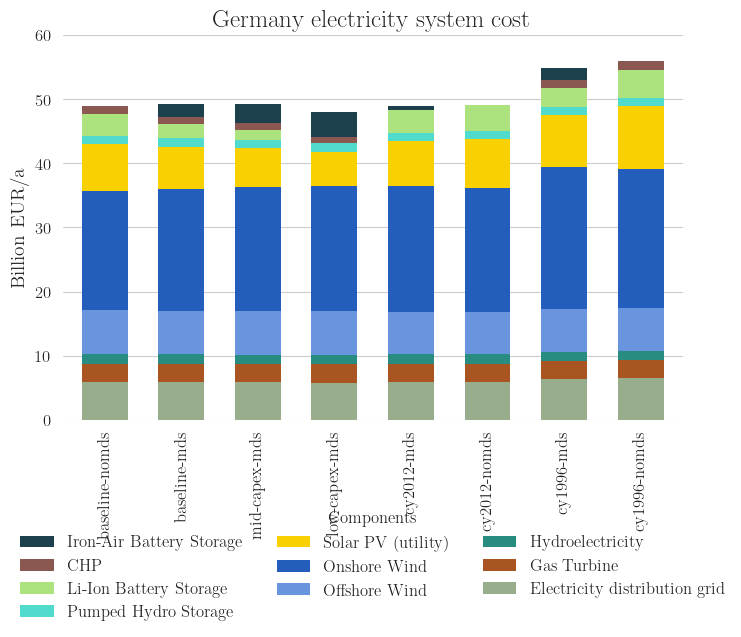

In [60]:
kpi_param = {
    'extract': "system cost",
    'include': ["DE"],
    'carrier_filter': "electricity+",
    'group_carrier': "pretty",
    'figsize': [8, 5],
    'plot_kw': {"title": "Germany electricity system cost",
                "ylim": [0,60],
                "ylabel": "Billion EUR/a",
                "width": 0.6
               }}

filter_scheme = config["kpi"].get("filter_scheme",{})
output = "test.pdf"

compare_scenarios(n_scenarios, kpi_param, filter_scheme, output)

## b. Plot Emission:

INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']


,baseline-nomds,color,baseline-mds,mid-capex-mds,low-capex-mds,cy2012-mds,cy2012-nomds,cy1996-mds,cy1996-nomds
Gas Turbine,13.945032,#a85522,13.804127,13.531306,13.208863,13.506189,13.561292,14.149283,13.616638
CHP,9.999815,#8a5751,9.739952,9.343730,8.887335,7.790902,7.994697,10.110602,10.254027


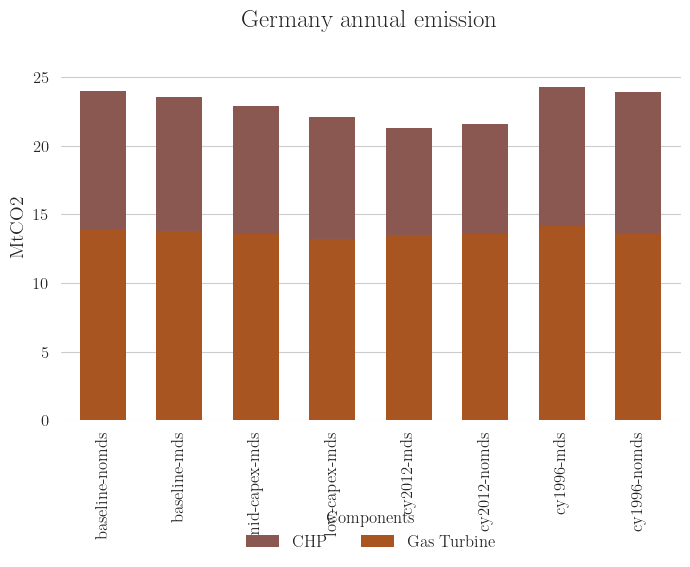

In [61]:
kpi_param = {
    'extract': "emission",
    'include': ["DE"],
    'carrier_filter': "electricity+",
    'group_carrier': "pretty",
    'figsize': [8, 5],
    'plot_kw': {"title": "Germany annual emission",
                "ylabel": "MtCO2",
                "width": 0.6
               }}

filter_scheme = config["kpi"].get("filter_scheme",{})
output = "test.pdf"

compare_scenarios(n_scenarios, kpi_param, filter_scheme, output)

## c. Plot Curtailment

INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']
INFO:plot_KPIs:include only ['DE']


,baseline-nomds,color,baseline-mds,mid-capex-mds,low-capex-mds,cy2012-mds,cy2012-nomds,cy1996-mds,cy1996-nomds
Hydroelectricity,40.674475,#298c81,35.347598,36.878205,32.575543,36.739278,44.875248,40.289196,35.613813
Offshore Wind,38053.887268,#6895dd,29831.409518,31441.085806,16956.615617,51731.693361,54379.892826,42968.127582,37338.049862
Onshore Wind,81506.346948,#235ebc,65833.578134,59252.993663,51275.990564,75341.771915,75081.719221,70754.372188,90300.626790
Solar PV (utility),24316.847681,#f9d002,16758.633619,11326.518311,6061.190558,22294.898359,28060.195966,26141.717773,44217.879728
Solar PV (rooftop),3919.254636,#ffea80,2991.327551,2307.316645,1882.608711,3239.911911,3303.499040,3532.844325,3606.241539


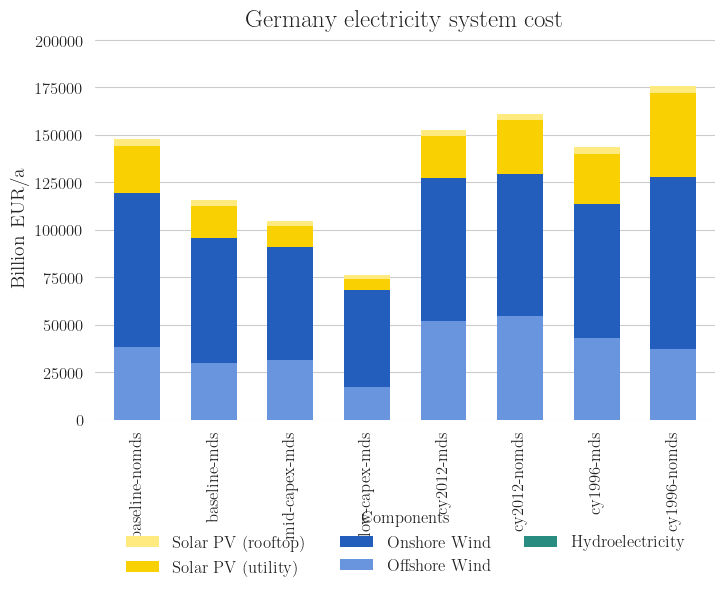

In [62]:
kpi_param = {
    'extract': "curtailment",
    'include': ["DE"],
    'carrier_filter': "power",
    'group_carrier': "pretty",
    'figsize': [8, 5],
    'plot_kw': {"title": "Germany electricity system cost",
                #"ylim": [0,60],
                "ylabel": "Billion EUR/a",
                "width": 0.6
               }}

filter_scheme = config["kpi"].get("filter_scheme",{})
output = "test.pdf"

compare_scenarios(n_scenarios, kpi_param, filter_scheme, output)

# Plotting Comparison (prices)

In [106]:
def violin_comp(data, title, output):
    fig, ax = plt.subplots() #figsize =(8, 3)
    
    new_index_order = list(data.columns)
    
    data_array = [data[c].to_numpy() for c in data.columns]
    
    parts = ax.violinplot(data_array, showmeans=True, showmedians=True)
    
    ax.set_ylabel("Marginal Price [€/MWh]")
    ax.grid(axis="y")
    
    #ax.set_ylim([-10, 600])

    for pc in parts['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_edgecolor('lightgrey')
        pc.set_alpha(1)

    for partname in ('cbars','cmins','cmaxes'):
        vp = parts[partname]
        vp.set_linewidth(0)
        
    vp = parts['cmeans']
    vp.set_edgecolor("black")
    vp.set_linewidth(6)

    vp = parts['cmaxes']
    print(vp)
    vp.set_edgecolor("red")
    vp.set_linewidth(6)

    vp = parts['cmedians']
    vp.set_edgecolor("blue")
    vp.set_linewidth(6)
    
    col = 1
    for c in data.columns:

        # Max data
        data_max = data[c].max()
        ax.annotate(str(round(data_max)),xy=(col,data_max), xytext=(0, 4), 
                    textcoords='offset points', ha='center', va='bottom', 
                    rotation=0, color = "red", size=12)

        # Mean data
        data_mean = data[c].mean()
        ax.annotate(str(round(data_mean)),xy=(col,data_mean), xytext=(0, 4), 
                    textcoords='offset points', ha='center', va='bottom', 
                    rotation=0, color = "black", size=12)

        # Median data
        data_median = data[c].median()
        ax.annotate(str(round(data_median)),xy=(col,data_median), xytext=(0, 4), 
                    textcoords='offset points', ha='center', va='bottom', 
                    rotation=0, color = "blue", size=12)        
        col += 1

    pypsa.plot.add_legend_patches(ax=ax, colors = ["blue","black","red"], labels = ["median","mean","max"],
                             legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.5, 1.00), 'frameon':False, 'ncol':3})

    ax.set_title(title, y=1.08)

    plt.xticks(range(1,len(data.columns)+1), list(data.columns), rotation=90)
    plt.grid(axis='both', color='0.95')
    plt.savefig(output)

def compare_violin(n_scenarios, include, title, output):
    df_all = pd.DataFrame()

    for scenario, n in n_scenarios.items():
    
        bus = n.buses.query("carrier == 'AC'")
        marginal = (n.buses_t.marginal_price * n.loads_t.p).loc[:,bus.index].rename(columns=bus.country).T.groupby("Bus").sum()
        marginal_country = n.loads_t.p.loc[:,bus.index].rename(columns=bus.country).T.groupby("Bus").sum()
        
        df = (marginal / marginal_country).T
    
        if include:
            df = df[include]
    
        df_data = pd.DataFrame(df.T.sum()).rename(columns={0:scenario})
        df_data = df_data.reset_index(drop = True)

        df_all = pd.concat([df_all,df_data], axis=1)
    
    violin_comp(df_all, title, output)

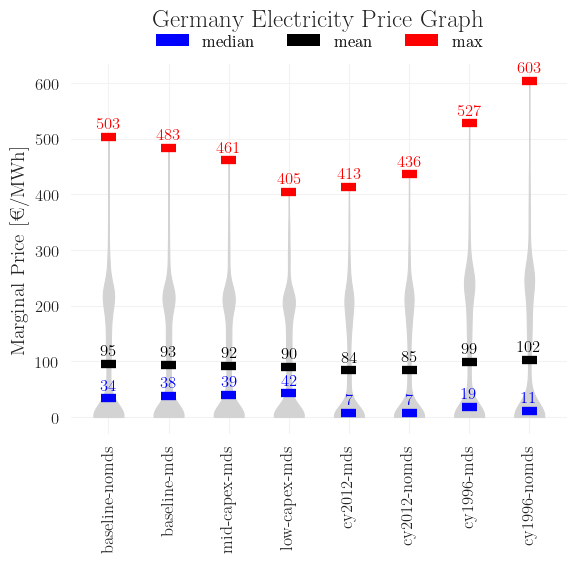

In [107]:
include = ["DE"]
title = "Germany Electricity Price Graph"
output = "test.pdf"

compare_violin(n_scenarios, include, title, output)

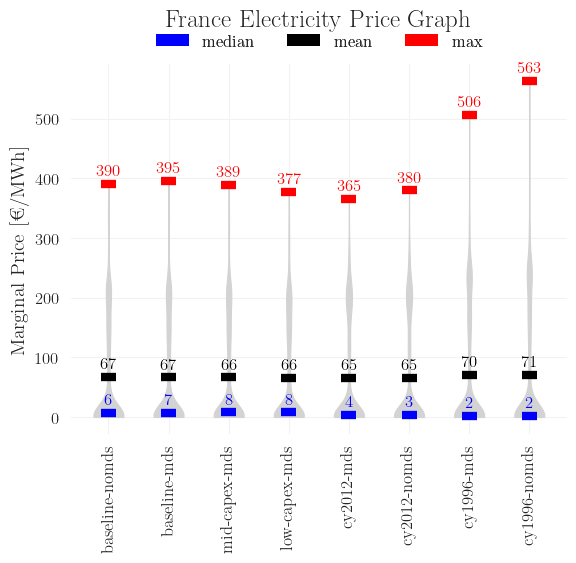

In [108]:
include = ["FR"]
title = "France Electricity Price Graph"
output = "test.pdf"

compare_violin(n_scenarios, include, title, output)